In [40]:
import re
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn.glm.thresholding import threshold_stats_img

from nilearn.masking import apply_mask
from nilearn.plotting import plot_design_matrix
from nilearn.input_data import NiftiSpheresMasker


pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## 0) Edit these paths + protocol constants

In [9]:
# ======================
# EDIT PATHS
# ======================
EVENTS_DIR   = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/events")  # motif-stroke_sub-*_run-*_events.tsv
LOGS_DIR     = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/log")     # motif-stroke_sub-*_run-*_*.csv
SEQ_DIR      = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/data/seq")     # stim_sequence_run-*.csv

FMRIPREP_ROOT = Path("/neurospin/motif-stroke/7T_protocol/pilots/derivatives/fmriprep")
RESULTS_DIR   = Path("/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/results_glm_3methods")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

TASK  = "motif4limbs"
SPACE = "MNI152NLin2009cAsym"

# ======================
# PROTOCOL CONSTANTS (from protocol.py)
# ======================
BLOCK_DURATION_MS = 10800
PAUSE_DURATION_MS = 4800
BLANK_MS = 1000
STIM_PER_BLOCK = 4
STIM_INTERVAL_MS = (BLOCK_DURATION_MS / STIM_PER_BLOCK) - 500  # exactly like protocol.py

BLANK_S = BLANK_MS / 1000.0
PAUSE_S = PAUSE_DURATION_MS / 1000.0
STIM_S  = STIM_INTERVAL_MS / 1000.0  # 2.2s

RESP_DUR_S = 0.2  # response window duration for log-based events

# ======================
# Design matrix options
# ======================
DEFAULT_USE_DRIFT = True
DEFAULT_DRIFT_MODEL = "cosine"
DEFAULT_HIGH_PASS = 0.01

DEFAULT_USE_CONFOUNDS = True
DEFAULT_INCLUDE_PHYSIO = False  
SMOOTHING_FWHM = 3.5

NOISE_MODEL = "ar1"
HRF_MODEL = "glover"

# ======================
# Contrasts (no explicit fix regressor)
# ======================
CONTRASTS = {
    "task_gt_baseline": "0.25*(main_gauche + main_droite + pied_gauche + pied_droit)",
    "hand_gt_foot": "0.5*(main_gauche + main_droite) - 0.5*(pied_gauche + pied_droit)",
    "foot_gt_hand": "0.5*(pied_gauche + pied_droit) - 0.5*(main_gauche + main_droite)",
    "left_gt_right": "0.5*(main_gauche + pied_gauche) - 0.5*(main_droite + pied_droit)",
    "right_gt_left": "0.5*(main_droite + pied_droit) - 0.5*(main_gauche + pied_gauche)",
}


## 1) Discovery: find all runs available from fMRIPrep (robust)

In [10]:
def discover_fmriprep_runs():
    """
    Returns list of dict entries:
      {sub:'02', run:'01', dir:'ap', bold:Path, mask:Path, conf:Path, func_dir:Path}
    """
    runs = []
    for sub_dir in sorted(FMRIPREP_ROOT.glob("sub-*")):
        func_dir = sub_dir / "func"
        if not func_dir.exists():
            continue

        bolds = sorted(func_dir.glob(
            f"sub-*_task-{TASK}_dir-*_run-*_space-{SPACE}_desc-preproc_bold.nii.gz"
        ))
        for bold in bolds:
            base = bold.name
            sub = re.search(r"sub-(\d+)", base).group(1)
            run = re.search(r"run-(\d+)", base).group(1)
            direc = re.search(r"dir-([a-z]+)", base).group(1)

            mask = func_dir / f"sub-{sub}_task-{TASK}_dir-{direc}_run-{run}_space-{SPACE}_desc-brain_mask.nii.gz"
            conf = func_dir / f"sub-{sub}_task-{TASK}_dir-{direc}_run-{run}_desc-confounds_timeseries.tsv"

            if mask.exists() and conf.exists():
                runs.append({
                    "sub": sub, "run": run, "dir": direc,
                    "bold": bold, "mask": mask, "conf": conf,
                    "func_dir": func_dir
                })
            else:
                # still record missing companions (for debugging)
                runs.append({
                    "sub": sub, "run": run, "dir": direc,
                    "bold": bold, "mask": mask, "conf": conf,
                    "func_dir": func_dir,
                    "missing": [str(p) for p in [mask, conf] if not p.exists()]
                })

    # keep only complete entries by default
    complete = [r for r in runs if ("missing" not in r)]
    return complete




## 2) The 3 event-building methods (this is the “3 matrices”)

In [11]:
## Method 1 — From events.tsv (event file)

def load_events_tsv(sub, run):
    # naming: motif-stroke_sub-3_run-1_events.tsv (no leading zeros)
    evt = EVENTS_DIR / f"motif-stroke_sub-{int(sub)}_run-{int(run)}_events.tsv"
    if not evt.exists():
        return None

    ev = pd.read_csv(evt, sep="\t")

    # ms -> s if needed
    if ev["onset"].max() > 1000:
        ev = ev.copy()
        ev["onset"] = ev["onset"] / 1000.0
        ev["duration"] = ev["duration"] / 1000.0

    ev = ev[["onset", "duration", "trial_type"]].copy()

    # remove explicit fix regressor (baseline is implicit)
    ev = ev.query("trial_type != 'fix'").copy()

    ev["modulation"] = 1.0
    return ev


## Method 2 — From log CSV (behavior / response timing)
KEYS = {"121", "98", "50", "49"}

def find_log_csv(sub, run):
    pattern = str(LOGS_DIR / f"motif-stroke_sub-{int(sub)}_run-{int(run)}_*.csv")
    files = sorted(glob.glob(pattern))
    return Path(files[-1]) if files else None

def events_from_log_response(sub, run, response_dur_s=RESP_DUR_S):
    log_path = find_log_csv(sub, run)
    if log_path is None:
        return None

    df = pd.read_csv(log_path)
    if "time" not in df.columns or "event" not in df.columns:
        return None

    df["time"] = df["time"].astype(float)
    df["event"] = df["event"].astype(str)

    ttl = df.loc[df["event"] == "TTL", "time"].values
    if len(ttl) == 0:
        return None
    t0 = ttl[0]

    # IMPORTANT: protocol logs are in ms clock time; convert to seconds relative to TTL
    df["t"] = (df["time"] - t0) / 1000.0

    rows = []
    i = 0
    while i < len(df):
        ev = df.iloc[i]["event"]
        t = float(df.iloc[i]["t"])

        if ev in ["main_gauche", "main_droite", "pied_gauche", "pied_droit"]:
            trial_type = ev

            # Search next keypress before next "stim marker"
            resp_time = None
            j = i + 1
            while j < len(df):
                ev2 = df.iloc[j]["event"]
                t2 = float(df.iloc[j]["t"])

                # stop when next segment begins
                if ev2 in ["main_gauche","main_droite","pied_gauche","pied_droit",
                           "fix","blank","End","Start","TTL"]:
                    break

                if ev2.isdigit() and ev2 in KEYS:
                    resp_time = t2
                    break
                j += 1

            if resp_time is not None:
                rows.append({
                    "onset": resp_time,
                    "duration": response_dur_s,
                    "trial_type": trial_type,
                    "modulation": 1.0
                })

        i += 1

    return pd.DataFrame(rows) if rows else None


## Method 3 — From stim_sequence_run-*.csv + protocol constants (planned timing)
def events_from_sequence(sub, run, t0=0.0):
    seq_path = SEQ_DIR / f"stim_sequence_run-{int(run)}.csv"
    if not seq_path.exists():
        return None

    seq = pd.read_csv(seq_path).sort_values(["block_id", "id"])

    rows = []
    current = float(t0)
    current_block = None

    for _, r in seq.iterrows():
        # new block => add pause
        if current_block is None:
            current_block = r["block_id"]
        elif r["block_id"] != current_block:
            current += PAUSE_S
            current_block = r["block_id"]

        # blank (not modeled)
        current += BLANK_S

        # stimulus window modeled as STIM_S
        rows.append({
            "onset": current,
            "duration": STIM_S,
            "trial_type": r["block_name"],
            "modulation": 1.0
        })

        current += STIM_S

    return pd.DataFrame(rows) if rows else None




## 3) Confounds + drift toggles (motion only by default)

In [12]:
def load_confounds(conf_path, use_confounds=True, include_physio=False):
    if not use_confounds:
        return None

    conf = pd.read_csv(conf_path, sep="\t")

    motion = [c for c in ["trans_x","trans_y","trans_z","rot_x","rot_y","rot_z"] if c in conf.columns]

    # fmriprep naming differs; catch common ones
    outliers = [c for c in conf.columns if ("motion_outlier" in c) or ("non_steady_state" in c)]

    cols = motion + outliers

    if include_physio:
        phys = [c for c in ["csf","white_matter","global_signal"] if c in conf.columns]
        cols += phys

    if len(cols) == 0:
        return None

    conf_sel = conf[cols].copy().fillna(0.0)
    return conf_sel

## 4) Build design matrix + fit GLM + compute basic metrics

In [13]:
def build_design_matrix(bold_img, events, confounds=None,
                        use_drift=True, drift_model="cosine", high_pass=0.01, hrf_model="glover"):
    n_scans = bold_img.shape[-1]
    tr = bold_img.header.get_zooms()[-1]
    frame_times = np.arange(n_scans) * tr

    add_regs = confounds.values if confounds is not None else None
    add_names = list(confounds.columns) if confounds is not None else None

    dm = make_first_level_design_matrix(
        frame_times=frame_times,
        events=events,
        hrf_model=hrf_model,
        drift_model=(drift_model if use_drift else None),
        high_pass=(high_pass if use_drift else None),
        add_regs=add_regs,
        add_reg_names=add_names,
    )
    return dm, tr


def fit_and_save(runinfo, method_name, events,
                 use_confounds, include_physio, use_drift, out_dir):
    out_dir.mkdir(parents=True, exist_ok=True)

    bold_img = nib.load(str(runinfo["bold"]))
    mask_img = str(runinfo["mask"])

    # timing sanity checks
    tr = bold_img.header.get_zooms()[-1]
    run_end = (bold_img.shape[-1] - 1) * tr
    last_end = float((events["onset"] + events["duration"]).max())
    if last_end > run_end + 1:
        print(f"⚠️  Timing mismatch? last_end={last_end:.2f}s > run_end≈{run_end:.2f}s")

    conf = load_confounds(runinfo["conf"], use_confounds=use_confounds, include_physio=include_physio)

    dm, tr2 = build_design_matrix(
        bold_img, events, confounds=conf,
        use_drift=use_drift, drift_model=DEFAULT_DRIFT_MODEL, high_pass=DEFAULT_HIGH_PASS,
        hrf_model=HRF_MODEL
    )

    # Save DM + collinearity
    dm.to_csv(out_dir / "design_matrix.csv", index=False)
    corr = dm.corr().replace([np.inf, -np.inf], np.nan).fillna(0)
    strong = (
        corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
    strong.head(50).to_csv(out_dir / "design_top_correlations.csv")

    flm = FirstLevelModel(
        t_r=tr2,
        mask_img=mask_img,
        hrf_model=HRF_MODEL,
        drift_model=(DEFAULT_DRIFT_MODEL if use_drift else None),
        high_pass=(DEFAULT_HIGH_PASS if use_drift else None),
        noise_model=NOISE_MODEL,
        smoothing_fwhm=SMOOTHING_FWHM,
        standardize=False,
        minimize_memory=False,
    ).fit(bold_img, design_matrices=dm)

    # R²
    r2_img = flm.r_square[0] if isinstance(flm.r_square, list) else flm.r_square
    r2_img.to_filename(str(out_dir / "r2.nii.gz"))
    r2_vals = apply_mask(r2_img, mask_img)
    mean_r2 = float(np.nanmean(r2_vals))

    # contrasts
    nvox_z_gt_3 = np.nan
    contrast_files = {}

    for cname, cexpr in CONTRASTS.items():
        zmap = flm.compute_contrast(cexpr, stat_type="t", output_type="z_score")
        z_path = out_dir / f"{cname}_z.nii.gz"
        zmap.to_filename(str(z_path))

        eff = flm.compute_contrast(cexpr, stat_type="t", output_type="effect_size")
        var = flm.compute_contrast(cexpr, stat_type="t", output_type="effect_variance")
        e_path = out_dir / f"{cname}_effect.nii.gz"
        v_path = out_dir / f"{cname}_variance.nii.gz"
        eff.to_filename(str(e_path))
        var.to_filename(str(v_path))

        contrast_files[cname] = {"z": z_path, "effect": e_path, "variance": v_path}

        if cname == "hand_gt_foot":
            zvals = apply_mask(zmap, mask_img)
            nvox_z_gt_3 = int(np.sum(zvals > 3.1))

    summary = {
        "sub": runinfo["sub"], "run": runinfo["run"], "dir": runinfo["dir"],
        "method": method_name,
        "use_confounds": use_confounds,
        "include_physio": include_physio,
        "use_drift": use_drift,
        "TR": tr2,
        "n_scans": bold_img.shape[-1],
        "n_events": int(len(events)),
        "n_regressors": int(dm.shape[1]),
        "mean_r2": mean_r2,
        "max_abs_corr": float(np.abs(strong.iloc[0])) if len(strong) else 0.0,
        "nvox_hand_gt_foot_z_gt_3p1": nvox_z_gt_3,
        "out_dir": str(out_dir),
        "bold_file": str(runinfo["bold"]),
    }
    return summary, contrast_files



## 5)  Subject-level fixed effects (combine runs within subject)

In [14]:
def subject_fixed_effects(entries, out_dir):
    """
    entries: list of dicts for one subject + one method
      each entry must contain:
        entry["contrast_files"][cname]["effect"] + ["variance"]
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    rows = []

    for cname in CONTRASTS.keys():
        eff_imgs, var_imgs = [], []
        used = 0

        for e in entries:
            eff_p = e["contrast_files"][cname]["effect"]
            var_p = e["contrast_files"][cname]["variance"]
            if eff_p.exists() and var_p.exists():
                eff_imgs.append(nib.load(str(eff_p)))
                var_imgs.append(nib.load(str(var_p)))
                used += 1

        if used == 0:
            continue

        out = compute_fixed_effects(eff_imgs, var_imgs)

        if len(out) == 2:
            subj_eff, subj_var = out
            subj_z = None
        elif len(out) == 3:
            subj_eff, subj_var, subj_z = out
        elif len(out) == 4:
            subj_eff, subj_var, subj_t, subj_z = out
        else:
            raise ValueError(f"Unexpected outputs: {len(out)}")

        eff_out = out_dir / f"{cname}_sub_effect.nii.gz"
        var_out = out_dir / f"{cname}_sub_variance.nii.gz"
        subj_eff.to_filename(str(eff_out))
        subj_var.to_filename(str(var_out))

        z_out = None
        if subj_z is not None:
            z_out = out_dir / f"{cname}_sub_z.nii.gz"
            subj_z.to_filename(str(z_out))

        rows.append({
            "contrast": cname,
            "n_runs_used": used,
            "effect_path": str(eff_out),
            "variance_path": str(var_out),
            "z_path": str(z_out) if z_out else None,
        })

    return pd.DataFrame(rows) if rows else pd.DataFrame()


## 6)  Main runner: all runs × 3 methods + subject summaries + fixed effects

In [15]:
def run_all_methods(use_confounds=DEFAULT_USE_CONFOUNDS,
                    include_physio=DEFAULT_INCLUDE_PHYSIO,
                    use_drift=DEFAULT_USE_DRIFT):

    runs = discover_fmriprep_runs()
    print(f"✅ Found {len(runs)} fMRIPrep run entries (sub/run/dir) for TASK={TASK}.")

    summaries = []
    buckets = {}  # (sub, method) -> list of entries with contrast_files

    for runinfo in runs:
        sub, run, direc = runinfo["sub"], runinfo["run"], runinfo["dir"]
        base_out = RESULTS_DIR / f"sub-{sub}" / f"run-{run}" / f"dir-{direc}"

        print("\n" + "="*90)
        print(f"SUB {sub} | RUN {run} | DIR {direc}")
        print("BOLD:", runinfo["bold"].name)

        # ---------- Method 1: events.tsv ----------
        ev1 = load_events_tsv(sub, run)
        if ev1 is not None and len(ev1):
            try:
                s, files = fit_and_save(runinfo, "events_tsv", ev1, use_confounds, include_physio, use_drift,
                                        base_out / "method_events_tsv")
                summaries.append(s)
                buckets.setdefault((sub, "events_tsv"), []).append({"contrast_files": files, "run": run, "dir": direc})
                print(f"✅ sub={sub} run={run} dir={direc} method=events_tsv n_events={len(ev1)} mean_r2={s['mean_r2']:.3f}")
            except Exception as e:
                print("❌", sub, run, direc, "events_tsv failed:", e)
        else:
            print("⚠️", sub, run, direc, "no events.tsv")

        # ---------- Method 2: log-based response ----------
        ev2 = events_from_log_response(sub, run, response_dur_s=RESP_DUR_S)
        if ev2 is not None and len(ev2):
            try:
                s, files = fit_and_save(runinfo, "log_response", ev2, use_confounds, include_physio, use_drift,
                                        base_out / "method_log_response")
                summaries.append(s)
                buckets.setdefault((sub, "log_response"), []).append({"contrast_files": files, "run": run, "dir": direc})
                print(f"✅ sub={sub} run={run} dir={direc} method=log_response n_events={len(ev2)} mean_r2={s['mean_r2']:.3f}")
            except Exception as e:
                print("❌", sub, run, direc, "log_response failed:", e)
        else:
            print("⚠️", sub, run, direc, "no log response events")

        # ---------- Method 3: sequence + protocol ----------
        ev3 = events_from_sequence(sub, run, t0=0.0)
        if ev3 is not None and len(ev3):
            try:
                s, files = fit_and_save(runinfo, "sequence_protocol", ev3, use_confounds, include_physio, use_drift,
                                        base_out / "method_sequence_protocol")
                summaries.append(s)
                buckets.setdefault((sub, "sequence_protocol"), []).append({"contrast_files": files, "run": run, "dir": direc})
                print(f"✅ sub={sub} run={run} dir={direc} method=sequence_protocol n_events={len(ev3)} mean_r2={s['mean_r2']:.3f}")
            except Exception as e:
                print("❌", sub, run, direc, "sequence_protocol failed:", e)
        else:
            print("⚠️", sub, run, direc, "no sequence file")

    df = pd.DataFrame(summaries)
    df.to_csv(RESULTS_DIR / "SUMMARY_all_methods_run_level.csv", index=False)

    # Per-subject summary (what you asked)
    if len(df):
        by_sub = (df.groupby(["sub", "method"])
                    .agg(n_runs=("mean_r2", "count"),
                         mean_r2=("mean_r2", "mean"),
                         mean_nvox_hand=("nvox_hand_gt_foot_z_gt_3p1", "mean"),
                         mean_maxcorr=("max_abs_corr", "mean"))
                    .reset_index())
        by_sub.to_csv(RESULTS_DIR / "SUMMARY_by_subject_and_method.csv", index=False)
        print("\n=== SUMMARY BY SUBJECT × METHOD (RUN-LEVEL METRICS) ===")
        print(by_sub.sort_values(["sub", "method"]))

    # Subject-level fixed effects
    subj_rows = []
    for (sub, method), entries in buckets.items():
        out_dir = RESULTS_DIR / f"sub-{sub}" / "subject_fixed_effects" / f"method-{method}"
        print("\n" + "-"*90)
        print(f"SUBJECT FIXED EFFECTS: sub={sub} method={method} n_runs={len(entries)}")
        df_sub = subject_fixed_effects(entries, out_dir)
        if len(df_sub):
            df_sub["sub"] = sub
            df_sub["method"] = method
            df_sub["n_run_entries_total"] = len(entries)
            subj_rows.append(df_sub)

    subj_df = pd.concat(subj_rows, ignore_index=True) if subj_rows else pd.DataFrame()
    subj_df.to_csv(RESULTS_DIR / "SUMMARY_subject_level_fixed_effects.csv", index=False)

    return df, subj_df



In [ ]:
# ======================
# 13) RUN
# ======================
run_df, subj_df = run_all_methods(
    use_confounds=False,     # toggle
    include_physio=False,    # keep False 
    use_drift=True           # keep True
)

print("\n✅ Done.")
print("Run-level summary:", RESULTS_DIR / "SUMMARY_all_methods_run_level.csv")
print("Subject-level summary:", RESULTS_DIR / "SUMMARY_subject_level_fixed_effects.csv")


✅ Found 5 fMRIPrep run entries (sub/run/dir) for TASK=motif4limbs.

SUB 02 | RUN 01 | DIR ap
BOLD: sub-02_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
⚠️  Timing mismatch? last_end=723.65s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=01 dir=ap method=events_tsv n_events=32 mean_r2=0.226
⚠️  Timing mismatch? last_end=634.35s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=01 dir=ap method=log_response n_events=126 mean_r2=0.231
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=01 dir=ap method=sequence_protocol n_events=128 mean_r2=0.255

SUB 02 | RUN 03 | DIR ap
BOLD: sub-02_task-motif4limbs_dir-ap_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
⚠️  Timing mismatch? last_end=767.38s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=03 dir=ap method=events_tsv n_events=32 mean_r2=0.347
⚠️  Timing mismatch? last_end=634.26s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=03 dir=ap method=log_response n_events=128 mean_r2=0.348
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=03 dir=ap method=sequence_protocol n_events=128 mean_r2=0.363

SUB 02 | RUN 02 | DIR pa
BOLD: sub-02_task-motif4limbs_dir-pa_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
⚠️  Timing mismatch? last_end=672.93s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=02 dir=pa method=events_tsv n_events=32 mean_r2=0.307
⚠️  Timing mismatch? last_end=634.38s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=02 dir=pa method=log_response n_events=127 mean_r2=0.307
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=02 run=02 dir=pa method=sequence_protocol n_events=128 mean_r2=0.330

SUB 03 | RUN 01 | DIR ap
BOLD: sub-03_task-motif4limbs_dir-ap_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
⚠️  Timing mismatch? last_end=621.51s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=03 run=01 dir=ap method=events_tsv n_events=32 mean_r2=0.256
⚠️ 03 01 ap no log response events
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=03 run=01 dir=ap method=sequence_protocol n_events=128 mean_r2=0.290

SUB 03 | RUN 02 | DIR pa
BOLD: sub-03_task-motif4limbs_dir-pa_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
⚠️  Timing mismatch? last_end=704.83s > run_end≈574.40s
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=03 run=02 dir=pa method=events_tsv n_events=32 mean_r2=0.223
⚠️ 03 02 pa no log response events
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/tmp/ipykernel_329101/795204623.py:54: UserWarning: If design matrices are supplied, [t_r] will be ignored.
  flm = FirstLevelModel(


✅ sub=03 run=02 dir=pa method=sequence_protocol n_events=128 mean_r2=0.260

=== SUMMARY BY SUBJECT × METHOD (RUN-LEVEL METRICS) ===
  sub             method  n_runs   mean_r2  mean_nvox_hand  mean_maxcorr
0  02         events_tsv       3  0.293323     2710.333333      0.248295
1  02       log_response       3  0.295168     2385.333333      0.218324
2  02  sequence_protocol       3  0.316085    41965.666667      0.217582
3  03         events_tsv       2  0.239336     4665.500000      0.239053
4  03  sequence_protocol       2  0.275237   157968.000000      0.226123

------------------------------------------------------------------------------------------
SUBJECT FIXED EFFECTS: sub=02 method=events_tsv n_runs=3

------------------------------------------------------------------------------------------
SUBJECT FIXED EFFECTS: sub=02 method=log_response n_runs=3

------------------------------------------------------------------------------------------
SUBJECT FIXED EFFECTS: sub=02 method=s

In [ ]:


def plot_3_design_matrices_for_run(
    results_dir,
    sub,
    run,
    direc,
    rescale=True,
    max_cols=None
):
    """
    Plot the 3 design matrices (events_tsv, log_response, sequence_protocol)
    for a given subject / run / direction, with clear titles.
    """

    base = Path(results_dir) / f"sub-{sub}" / f"run-{run}" / f"dir-{direc}"

    paths = {
        "events_tsv": base / "method_events_tsv" / "design_matrix.csv",
        "log_response": base / "method_log_response" / "design_matrix.csv",
        "sequence_protocol": base / "method_sequence_protocol" / "design_matrix.csv",
    }

    for method, p in paths.items():
        if not p.exists():
            print(f"⚠️ sub={sub} run={run} dir={direc} method={method} → missing design matrix")
            continue

        dm = pd.read_csv(p)

        # Optionally reduce number of columns for readability
        if max_cols is not None and dm.shape[1] > max_cols:
            keep = []
            task_regs = ["main_gauche","main_droite","pied_gauche","pied_droit"]
            for c in task_regs:
                if c in dm.columns:
                    keep.append(c)
            if "constant" in dm.columns:
                keep.append("constant")

            for c in dm.columns:
                if c not in keep:
                    keep.append(c)
                if len(keep) >= max_cols:
                    break

            dm = dm[keep]

        # ---- PLOT ----
        print(f"✅ sub={sub} run={run} dir={direc} method={method}")

        fig = plot_design_matrix(dm, rescale=rescale)
        fig.figure.suptitle(
            f"Design matrix — sub-{sub} | run-{run} | dir-{direc} | method={method}",
            fontsize=14,
            y=1.02
        )
        plt.show()


## 7)  Visualize The Matrices

In [26]:
def plot_all_runs_for_subject(results_dir, sub, max_cols=18):
    base = Path(results_dir) / f"sub-{sub}"
    if not base.exists():
        print(f"No results found for sub-{sub}")
        return

    for run_dir in sorted(base.glob("run-*")):
        run = run_dir.name.split("-")[1]
        for dir_dir in sorted(run_dir.glob("dir-*")):
            direc = dir_dir.name.split("-")[1]
            plot_3_design_matrices_for_run(
                results_dir,
                sub=sub,
                run=run,
                direc=direc,
                rescale=True,
                max_cols=max_cols
            )


✅ sub=03 run=01 dir=ap method=events_tsv


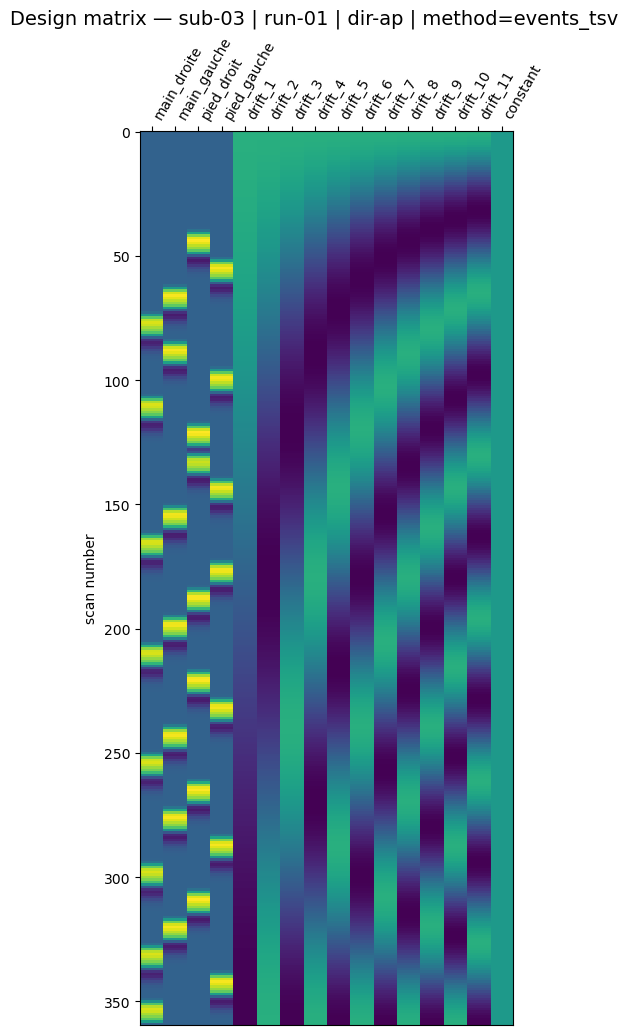

⚠️ sub=03 run=01 dir=ap method=log_response → missing design matrix
✅ sub=03 run=01 dir=ap method=sequence_protocol


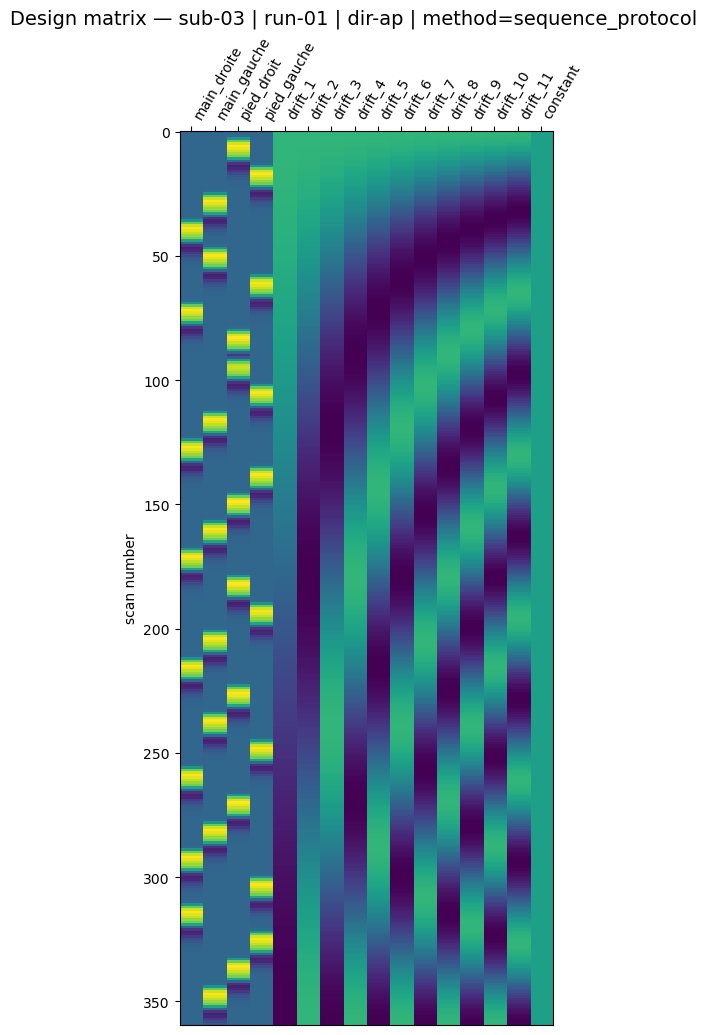

✅ sub=03 run=02 dir=pa method=events_tsv


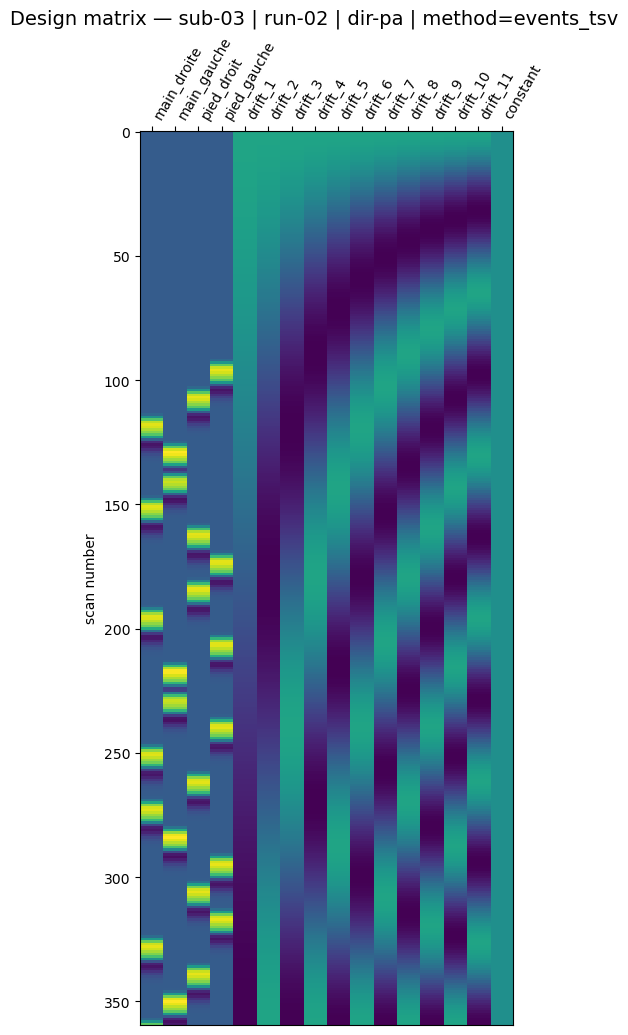

⚠️ sub=03 run=02 dir=pa method=log_response → missing design matrix
✅ sub=03 run=02 dir=pa method=sequence_protocol


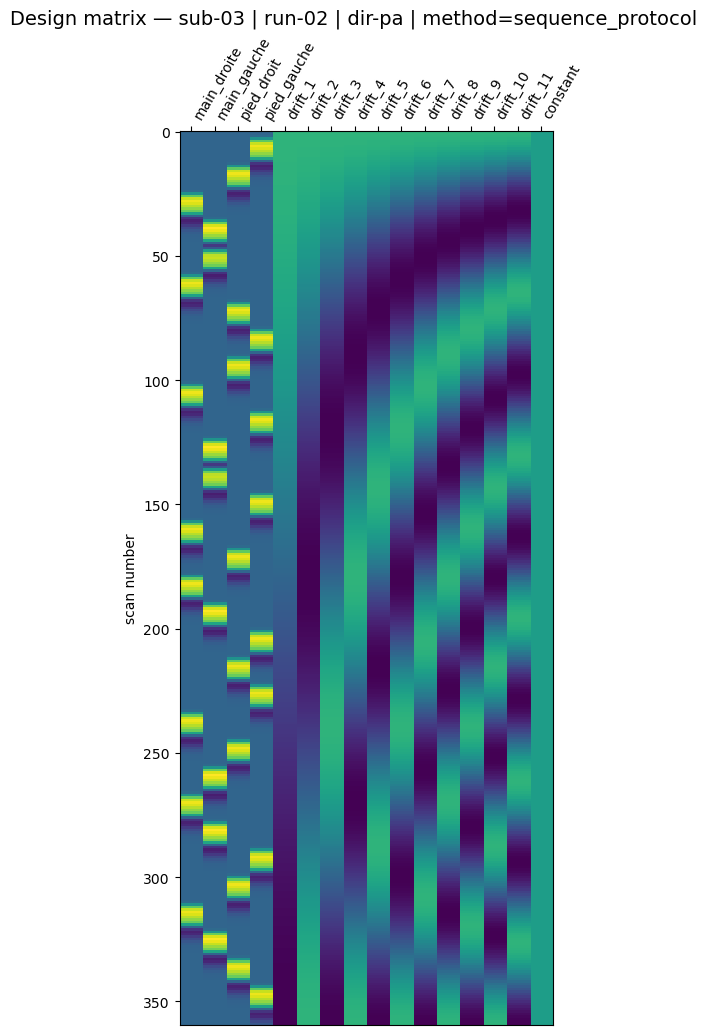

In [39]:
plot_all_runs_for_subject(
    "/volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/results_glm_3methods",
    sub="03"
)


In [ ]:
# # Example: subject 02, run 01
# df_events = load_events_tsv(sub="02", run="01")

# df_events.head(20)
# """  """


# # Example: subject 02, run 01
# df_seq = events_from_sequence(sub="02", run="01", t0=0.0)

# df_seq.head(20)


# # Example: subject 02, run 01
# df_log = events_from_log_response(sub="02", run="01")

# df_log.head(20)

,onset,duration,trial_type,modulation
0,1.0,2.2,pied_droit,1.0
1,4.2,2.2,pied_droit,1.0
2,7.4,2.2,pied_droit,1.0
3,10.6,2.2,pied_droit,1.0
4,18.6,2.2,pied_gauche,1.0
5,21.8,2.2,pied_gauche,1.0
6,25.0,2.2,pied_gauche,1.0
7,28.2,2.2,pied_gauche,1.0
8,36.2,2.2,main_gauche,1.0
9,39.4,2.2,main_gauche,1.0


## 8)  Analyze the design matrices and contrasts: sanity checks, collinearity, R², contrast values, etc. --- IGNORE ---

In [ ]:
# ============================================================
# A + B + C: Inspect effect / variance / z, do FDR, ROI summaries
# Uses your already-defined:
#   - RESULTS_DIR (Path)
#   - CONTRASTS (dict of contrast expressions)
# ============================================================



# ----------------------------
# Choose method + contrasts
# ----------------------------
METHOD = "sequence_protocol"  
CONTRASTS_TO_CHECK = ["hand_gt_foot", "foot_gt_hand"] 

# safety check
missing = [c for c in CONTRASTS_TO_CHECK if c not in CONTRASTS]
if missing:
    raise ValueError(f"These contrasts are not in CONTRASTS dict: {missing}")

# ----------------------------
# Thresholding settings
# ----------------------------
FDR_Q = 0.05
CLUSTER_THRESH = None  # set e.g. 50 to remove tiny clusters, or None to disable

# ----------------------------
# ROI specs (MNI coords, approx)
# ----------------------------
ROI_SPECS = {
    "M1_left_hand_knob": {"coords": [(-38, -26, 56)], "radius": 8},
    "M1_medial_foot": {"coords": [(0, -30, 70)], "radius": 10},
}

# ----------------------------
# Find method folders produced by the pipeline
# ----------------------------
def iter_method_dirs(results_dir: Path, method_name: str):
    """
    Yields (sub, run, dir, method_dir)
    method_dir example:
      RESULTS_DIR/sub-02/run-01/dir-ap/method_sequence_protocol
    """
    for sub_dir in sorted(results_dir.glob("sub-*")):
        sub = sub_dir.name.split("-")[1]
        for run_dir in sorted(sub_dir.glob("run-*")):
            run = run_dir.name.split("-")[1]
            for dir_dir in sorted(run_dir.glob("dir-*")):
                direc = dir_dir.name.split("-")[1]
                mdir = dir_dir / f"method_{method_name}"
                if mdir.exists():
                    yield sub, run, direc, mdir

# ----------------------------
# Load the 3 images saved by the fit_and_save()
# ----------------------------
def load_contrast_triplet(method_dir: Path, contrast: str):
    eff = method_dir / f"{contrast}_effect.nii.gz"
    var = method_dir / f"{contrast}_variance.nii.gz"
    z   = method_dir / f"{contrast}_z.nii.gz"
    if not (eff.exists() and var.exists() and z.exists()):
        return None
    return eff, var, z

# ----------------------------
# FDR thresholding on z-map
# ----------------------------
def save_fdr_thresholded(z_path: Path, out_dir: Path, q=0.05, cluster_threshold=None):
    z_img = nib.load(str(z_path))
    thr_img, zthr = threshold_stats_img(
        z_img,
        alpha=q,
        height_control="fdr",
        cluster_threshold=cluster_threshold if cluster_threshold is not None else 0,
    )
    out_img = out_dir / f"{z_path.stem}_FDRq{q}_thr.nii.gz"
    thr_img.to_filename(str(out_img))
    return float(zthr), out_img

# ----------------------------
# ROI extraction (mean in spheres)
# ----------------------------
def roi_extract_mean(img_path: Path, roi_specs: dict):
    img = nib.load(str(img_path))
    out = {}
    for roi_name, spec in roi_specs.items():
        masker = NiftiSpheresMasker(
            seeds=spec["coords"],
            radius=spec["radius"],
            detrend=False,
            standardize=False,
        )
        vals = masker.fit_transform(img)  # for 3D -> (1, n_seeds)
        out[roi_name] = float(np.nanmean(vals))
    return out

# ----------------------------
# Main analysis
# ----------------------------
def analyze_method_AB_C(results_dir: Path, method_name: str, contrasts_to_check):
    rows = []

    for sub, run, direc, mdir in iter_method_dirs(results_dir, method_name):
        report_dir = mdir / "report_AB_C"
        report_dir.mkdir(parents=True, exist_ok=True)

        for con in contrasts_to_check:
            triplet = load_contrast_triplet(mdir, con)
            if triplet is None:
                print(f"⚠️ Missing triplet: sub={sub} run={run} dir={direc} method={method_name} con={con}")
                continue

            eff_path, var_path, z_path = triplet

            # B) FDR threshold z-map
            zthr, z_fdr_path = save_fdr_thresholded(
                z_path, report_dir, q=FDR_Q, cluster_threshold=CLUSTER_THRESH
            )

            # C) ROI means for each of the 3 maps + the FDR-thresholded z
            eff_rois = roi_extract_mean(eff_path, ROI_SPECS)
            var_rois = roi_extract_mean(var_path, ROI_SPECS)
            z_rois   = roi_extract_mean(z_path, ROI_SPECS)
            zf_rois  = roi_extract_mean(z_fdr_path, ROI_SPECS)

            for roi_name in ROI_SPECS.keys():
                rows.append({
                    "sub": sub, "run": run, "dir": direc,
                    "method": method_name, "contrast": con, "roi": roi_name,
                    "effect_mean": eff_rois[roi_name],
                    "variance_mean": var_rois[roi_name],
                    "z_mean": z_rois[roi_name],
                    "z_fdrthr_mean": zf_rois[roi_name],
                    "fdr_q": FDR_Q,
                    "zthr_fdr": zthr,
                    "effect_img": str(eff_path),
                    "variance_img": str(var_path),
                    "z_img": str(z_path),
                    "z_fdr_img": str(z_fdr_path),
                    "report_dir": str(report_dir),
                })

            print(f"✅ sub={sub} run={run} dir={direc} con={con} | FDR zthr={zthr:.2f}")

    df = pd.DataFrame(rows)

    out_csv = results_dir / f"ROI_REPORT_{method_name}_FDRq{FDR_Q}.csv"
    df.to_csv(out_csv, index=False)
    print("Saved run-level ROI report:", out_csv)

    if len(df):
        summary = (df.groupby(["sub", "contrast", "roi"])
                     .agg(
                         n_runs=("run", "nunique"),
                         mean_effect=("effect_mean", "mean"),
                         mean_z=("z_mean", "mean"),
                         mean_z_fdr=("z_fdrthr_mean", "mean"),
                         mean_zthr=("zthr_fdr", "mean"),
                     )
                     .reset_index())
        out_sum = results_dir / f"ROI_REPORT_{method_name}_SUMMARY.csv"
        summary.to_csv(out_sum, index=False)
        print("Saved subject-level ROI summary:", out_sum)
        display(summary)

    return df

# Run it:
df_roi = analyze_method_AB_C(RESULTS_DIR, METHOD, CONTRASTS_TO_CHECK)


/tmp/ipykernel_329101/3117231254.py:14: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiSpheresMasker


✅ sub=02 run=01 dir=ap con=hand_gt_foot | FDR zthr=2.61
✅ sub=02 run=01 dir=ap con=foot_gt_hand | FDR zthr=2.61
✅ sub=02 run=02 dir=pa con=hand_gt_foot | FDR zthr=2.69
✅ sub=02 run=02 dir=pa con=foot_gt_hand | FDR zthr=2.69
✅ sub=02 run=03 dir=ap con=hand_gt_foot | FDR zthr=2.85
✅ sub=02 run=03 dir=ap con=foot_gt_hand | FDR zthr=2.85
✅ sub=03 run=01 dir=ap con=hand_gt_foot | FDR zthr=2.22
✅ sub=03 run=01 dir=ap con=foot_gt_hand | FDR zthr=2.22
✅ sub=03 run=02 dir=pa con=hand_gt_foot | FDR zthr=2.30
✅ sub=03 run=02 dir=pa con=foot_gt_hand | FDR zthr=2.30
Saved run-level ROI report: /volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/results_glm_3methods/ROI_REPORT_sequence_protocol_FDRq0.05.csv
Saved subject-level ROI summary: /volatile/home/sb283337/Bureau/7T-fMRI-Motor-Stroke/results_glm_3methods/ROI_REPORT_sequence_protocol_SUMMARY.csv


,sub,contrast,roi,n_runs,mean_effect,mean_z,mean_z_fdr,mean_zthr
0,02,foot_gt_hand,M1_left_hand_knob,3,-1.392026,-8.492047,-8.454494,2.716798
1,02,foot_gt_hand,M1_medial_foot,3,0.916221,4.646329,4.435216,2.716798
2,02,hand_gt_foot,M1_left_hand_knob,3,1.392026,8.492047,8.454494,2.716798
3,02,hand_gt_foot,M1_medial_foot,3,-0.916221,-4.646329,-4.435216,2.716798
4,03,foot_gt_hand,M1_left_hand_knob,2,-1.937209,-8.743505,-8.680482,2.262727
5,03,foot_gt_hand,M1_medial_foot,2,1.607918,7.247191,7.171445,2.262727
6,03,hand_gt_foot,M1_left_hand_knob,2,1.937209,8.743505,8.680482,2.262727
7,03,hand_gt_foot,M1_medial_foot,2,-1.607918,-7.247191,-7.171445,2.262727



## 🧠 ROI-based interpretation (sequence-protocol model, FDR-corrected)

### What was done

* We focused on the **sequence_protocol design** (protocol-based timing), which gave the most stable run-level metrics.
* Two **a-priori motor ROIs** were defined (independent of the data):

  * **Left M1 hand knob** → expected to respond more to *hand* movements
  * **Medial M1 (foot area)** → expected to respond more to *foot* movements
* For each subject and run:

  * We computed **Hand > Foot** and **Foot > Hand** contrasts
  * We examined **effect size**, **z-score**, and **FDR-corrected z-score (q < 0.05)**


### Multiple-comparison correction (FDR)

* FDR controls the **expected proportion of false positives** across all voxels.
* The reported **zthr** (≈ 2.2–2.8) is the **minimum z-value required to survive FDR correction**.
* All reported effects **clearly exceed** this threshold (|z| ≈ 4–9).


### Subject-level results: motor somatotopy

#### Subject 02 (3 runs)

* **Hand > Foot**

  * Left M1 hand knob: **strong positive effect** (mean z ≈ +8.5)
  * Medial foot area: **negative effect** (mean z ≈ −4.6)

* **Foot > Hand**

  * Medial foot area: **positive effect** (mean z ≈ +4.6)
  * Hand knob: **negative effect** (mean z ≈ −8.5)
* All effects survive **FDR correction** consistently across runs.

➡️ Interpretation: **clear and stable motor somatotopy**, as expected physiologically.



#### Subject 03 (2 runs)

* **Hand > Foot**

  * Left M1 hand knob: **very strong positive effect** (mean z ≈ +8.7)
  * Medial foot area: **negative effect** (mean z ≈ −7.2)
* **Foot > Hand**

  * Medial foot area: **strong positive effect** (mean z ≈ +7.2)
  * Hand knob: **negative effect** (mean z ≈ −8.7)
* All effects survive **FDR correction**.

Interpretation: **same somatotopic pattern as Subject 02**, despite fewer runs.


### Key take-home messages

* The **expected hand–foot dissociation in M1 is recovered** in both subjects.
* Effects are:

  * **large in magnitude** (high z)
  * **consistent across runs**
  * **robust to FDR correction**






## 9 )SUBJECT-LEVEL FIXED EFFECTS + PLOTS (per subject × method)